# ARIMA for Bitcoin weekly mean close price in USD

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import itertools

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Data selection

In [3]:
data_folder = './g-research-crypto-forecasting/'

train = pd.read_csv(data_folder + 'train.csv')

In [4]:
def get_asset(asset_id, data = train):
    df = data[data['Asset_ID'] == asset_id].reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df

btc = get_asset(asset_id=1)
btc_weekly = btc.resample('W').mean()
data = btc_weekly.Close
data.index.freq=None

## Train, validation, test data split

All data size: 195
Train data size: 117
Validation data size: 39
Test data size: 39


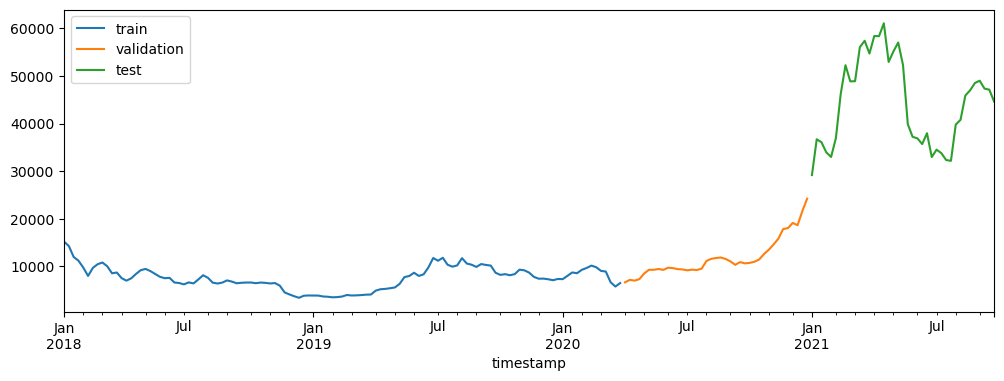

In [5]:
data_train, data_test = train_test_split(data, test_size=0.4, shuffle=False)
data_val, data_test = train_test_split(data_test, test_size=0.5, shuffle=False)
print('All data size: %d' % data.size)
print('Train data size: %d' % data_train.size)
print('Validation data size: %d' % data_val.size)
print('Test data size: %d' % data_test.size)
plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':100})
data_train.plot(label="train")
data_val.plot(label="validation")
data_test.plot(label="test")
plt.legend()

## Autocorrelation and stationary check

In [6]:
r = adfuller(data_train)
print('Original series')
print('ADF Statistic: %f' % r[0])
print('p-value: %f' % r[1], '\n')
r = adfuller(data_train.diff(periods=1).dropna())
print('1st Differencing')
print('ADF Statistic: %f' % r[0])
print('p-value: %f' % r[1], '\n')
r = adfuller(data_train.diff(periods=2).dropna())
print('2nd Differencing')
print('ADF Statistic: %f' % r[0])
print('p-value: %f' % r[1], '\n')

Original series
ADF Statistic: -2.009687
p-value: 0.282342 

1st Differencing
ADF Statistic: -3.822698
p-value: 0.002683 

2nd Differencing
ADF Statistic: -4.013238
p-value: 0.001343 



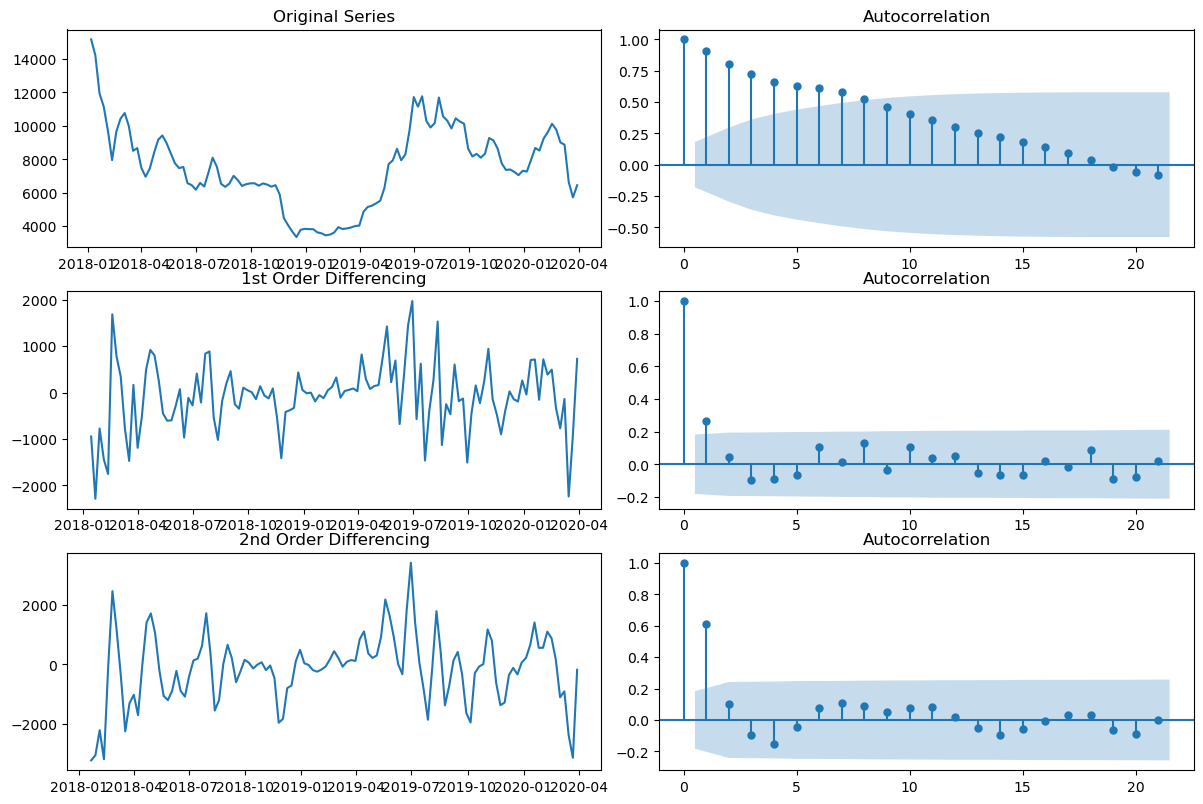

In [7]:
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':100})

# Original Series
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes[0, 0].plot(data_train); axes[0, 0].set_title('Original Series')
_ = plot_acf(data_train, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_train.diff(periods=1)); axes[1, 0].set_title('1st Order Differencing')
_ = plot_acf(data_train.diff(periods=1).dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_train.diff(periods=2)); axes[2, 0].set_title('2nd Order Differencing')
_ = plot_acf(data_train.diff(periods=2).dropna(), ax=axes[2, 1])

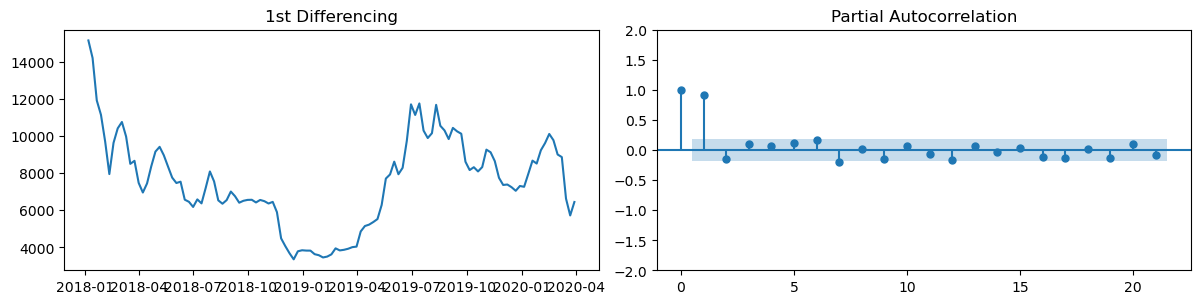

In [8]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

fig, axes = plt.subplots(1, 2)
fig.tight_layout()
axes[0].plot(data_train); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(-2, 2))
_ = plot_pacf(data_train.dropna(), ax=axes[1])

In [9]:
p = range(8)
d = [1]
q = range(5)
pdq = list(itertools.product(p,d,q))

results = []
best_mse = float("inf")

for param in pdq:
    try:
        model = ARIMA(data_train, order=param)
        model_fit = model.fit()
    except ValueError:
        print('bad parameter combination:', param)
        continue
    fc_val, _, _ = model_fit.forecast(data_val.size)
    mse = mean_squared_error(data_val, fc_val)
    if mse < best_mse:
        best_model = model_fit
        best_mse = mse
        best_param = param
    results.append([param, mse])

C:\Users\Crews\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Crews\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

bad parameter combination: (1, 1, 2)
bad parameter combination: (1, 1, 3)
bad parameter combination: (1, 1, 4)


C:\Users\Crews\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Crews\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

bad parameter combination: (2, 1, 3)
bad parameter combination: (2, 1, 4)


C:\Users\Crews\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Crews\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

LinAlgError: SVD did not converge

In [10]:
print("Best MSE: ", best_mse)
print("Best params: ", best_param)
print(best_model.summary())

Best MSE:  56184870.96730127
Best params:  (3, 1, 1)
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  116
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -923.885
Method:                       css-mle   S.D. of innovations            695.706
Date:                Wed, 13 Apr 2022   AIC                           1859.769
Time:                        09:22:08   BIC                           1876.291
Sample:                    01-14-2018   HQIC                          1866.476
                         - 03-29-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -63.8706     71.611     -0.892      0.372    -204.225      76.483
ar.L1.D.Close     0.5374      0.465      1.154      0.248      -0.375

C:\Users\Crews\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


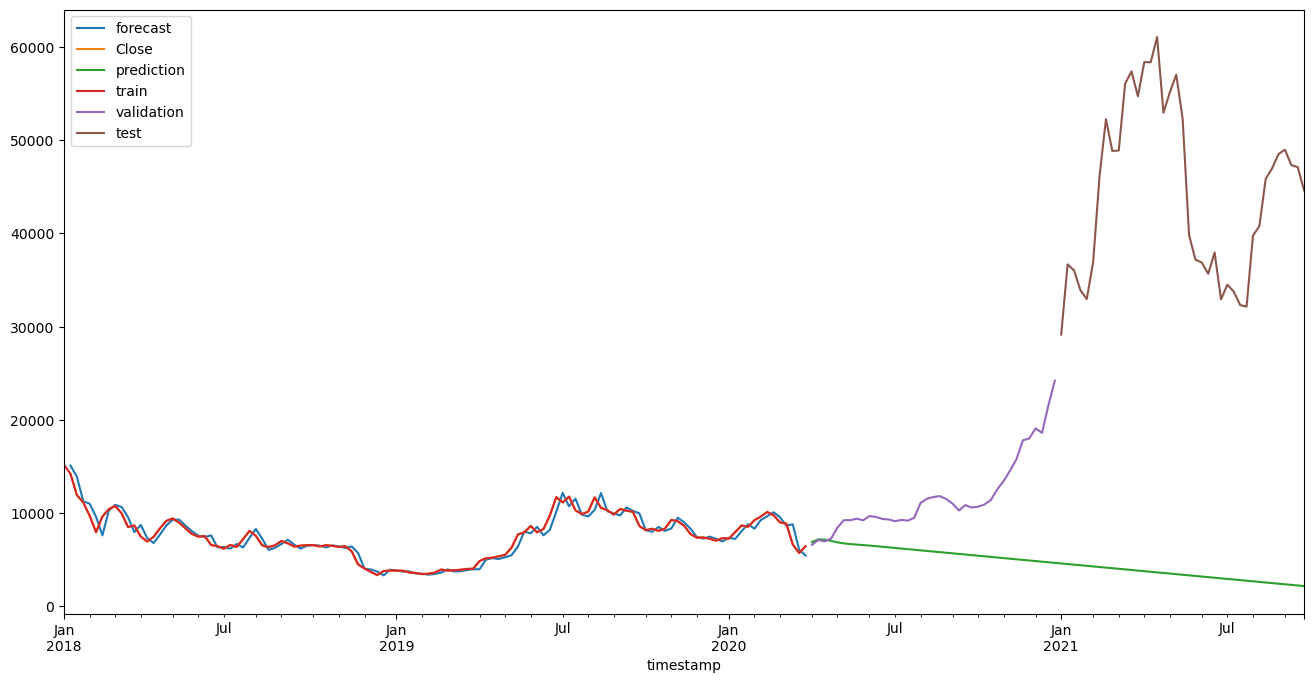

In [11]:
plt.rcParams.update({'figure.figsize':(16,8), 'figure.dpi':100})

fc, _, _ = best_model.forecast(data_val.size + data_test.size)
fc_series = pd.Series(fc, index = np.concatenate((data_val.index, data_test.index), axis=0))


best_model.plot_predict()
fc_series.plot(label="prediction")
data_train.plot(label="train")
data_val.plot(label="validation")
data_test.plot(label="test")
plt.legend()

In [18]:
datetime.fromtimestamp(train.timestamp[0])

datetime.datetime(2018, 1, 1, 3, 1)